## Prepare datasets

In [ ]:
import sys
sys.path.append("..")  # Adjust the path to import from the parent directory
from src.dataset.dataset import (
    build_hsi_dataloader,
    build_FIVES_random_crops_dataloaders,
    build_hsi_testloader
)

trainloader_FIVES = (
    build_FIVES_random_crops_dataloaders(
        batch_size=16,
        num_channels=1,
        # kernel_size=11,
        # sigma=(10, 20),
    )
)[0]

window = (500, 600)
target_augmented = True
trainloader_HSI = build_hsi_dataloader(
    batch_size=1,
    train_split=1,
    val_split=0,
    test_split=0,
    window=window,
    exclude_labeled_data=True,
    augmented=target_augmented,
)[0]

testloader_HSI = build_hsi_testloader(
    window=window,
    batch_size=1
)

print(len(trainloader_HSI.dataset), len(testloader_HSI.dataset))

Number of samples in the training set: 534, validation set: 60
Number of samples in the test set: 200
62 5


## Plot Intensity

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from src.util.visualize_data import plot_intensity, plot_intensity_for_label


plot_intensity_for_label(trainloader_FIVES, title="Intensity Distribution of background (FIVES)", label=0)
# plot_intensity(trainloader_HSI, title=f'Intensity Distribution of HSI Dataset {window}')
plot_intensity_for_label(testloader_HSI, title=f"Intensity Distribution of bloodvessels in HSI Dataset {window}", label=1)
plot_intensity_for_label(testloader_HSI, title=f"Intensity Distribution of background in HSI Dataset {window}", label=0)


## SNR

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from src.util.visualize_data import plot_snr_distribution
    
plot_snr_distribution(trainloader_FIVES, title="SNR Distribution of FIVES Dataset")
plot_snr_distribution(testloader_HSI, title=f"SNR Distribution of HSI Test Dataset {window}")
plot_snr_distribution(trainloader_HSI, title=f"SNR Distribution of HSI Train Dataset {window}")

## Inspect HSI Data

/home/home/tim_ivan/idp/notebooks/../src/util/visualize_data.py:70: UserWarning: You passed a edgecolor/edgecolors ([]) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  scatter_plot = ax_img.scatter([], [], c=[], s=100, marker="+", edgecolors=[])


Button(description='Toggle Gaussians', style=ButtonStyle())

Button(description='Clear Selections', style=ButtonStyle())

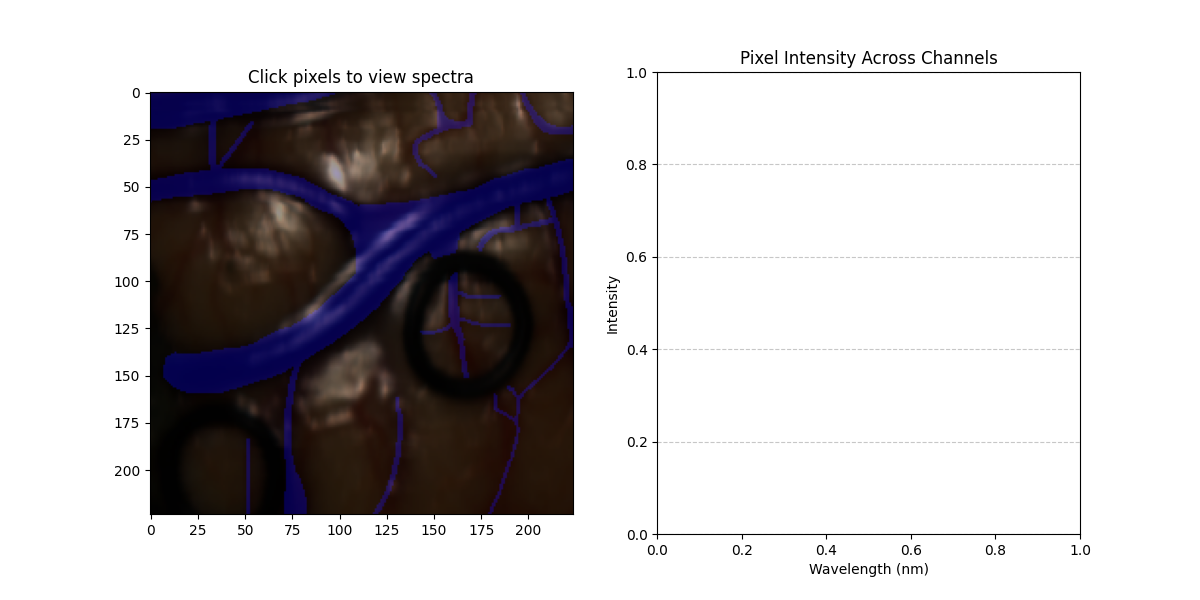

In [3]:
from src.util.visualize_data import show_interactive_image_with_spectrum
from src.util.constants import MODELS_DIR
%matplotlib widget
model_path = MODELS_DIR / "gcr_comic-sweep.pth"
show_interactive_image_with_spectrum(image_id=0, gcr_path=model_path)

## Save Windowed HSI Images to Directory

In [ ]:
from PIL import Image
import numpy as np
import os
from src.dataset.dataset import build_hsi_testloader

# Ensure the directory exists
output_dir = f"out/hsi"
os.makedirs(output_dir, exist_ok=True)

for i in range(0, 600):
    testloader_HSI_windowed = build_hsi_testloader(window=(400 + i, 400 + i + 2))
    
    for image_index in range(2,4):
        # Extract pixel intensities across all channels
        input_image = (
            testloader_HSI_windowed.dataset[image_index][0].cpu().numpy().squeeze()
        )  # Convert to HWC format
        input_image = np.stack(
            [input_image, input_image, input_image], axis=-1
        )  # Convert to 3-channel grayscale RGB

        image_min = input_image.min()
        image_max = input_image.max()

        # Apply min-max normalization to scale values to [0, 255]
        input_image = 255 * (input_image - image_min) / (image_max - image_min)
        input_image = input_image.astype(np.uint8)  # Convert to uint8 after scaling

        # Convert NumPy array to PIL Image and save
        pil_image = Image.fromarray(input_image)
        pil_image.save(f"{output_dir}/image_{image_index}/HSI_window_{400+i}_{400+i+2}.png")

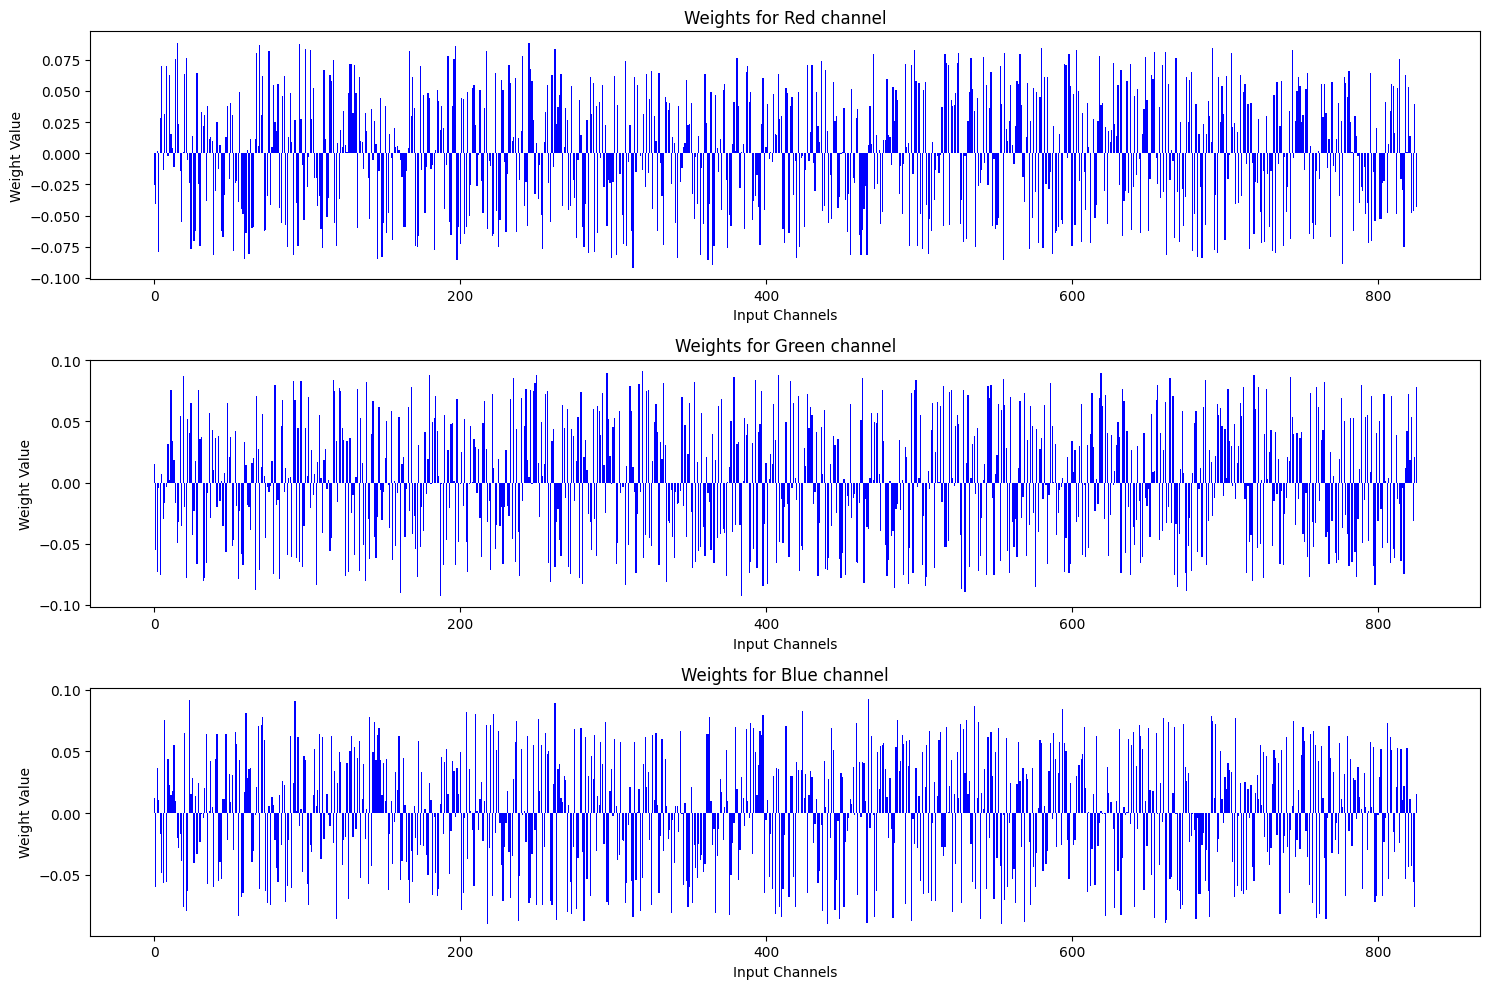

In [ ]:
from src.training.train_autoencoder import build_conv_channel_reducer
import torch
import matplotlib.pyplot as plt
import numpy as np

model_path = MODELS_DIR / "convReducer.pth"
conv_reducer = build_conv_channel_reducer(
    num_input_channels=826,
    num_reduced_channels=3,
    load_from_path=model_path,
    device=torch.device("cuda:1")
)

weights = conv_reducer.conv1x1.weight.detach().cpu().numpy()

# weights shape: (3, 826)
# Create a figure to plot the bar plots
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
channel_names = ['Red', 'Green', 'Blue']

for i in range(3):
    ax = axes[i]
    ax.bar(np.arange(weights.shape[1]), weights[i].flatten(), color='blue')  # Flatten ensures correct shape for plotting
    ax.set_title(f"Weights for {channel_names[i]} channel")
    ax.set_xlabel("Input Channels")
    ax.set_ylabel("Weight Value")

plt.tight_layout()
plt.show()